# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' ## 그림 더 선명하게

In [3]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
import random

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [6]:
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [7]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])
    roc_auc = roc_auc_score(y_test, y_pred, labels=[True, False])
    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))
    print(classification_report(y_test, y_pred, labels=[True, False]))
    print("ROC AUC Score: {}".format(roc_auc))

### 데이터 읽어오기


In [11]:
train_data = pd.read_csv('data/train.csv')

In [12]:
test_data = pd.read_csv('data/test.csv')
submission = pd.read_csv('submission.csv')

In [13]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave']=train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(-999)

train_data=train_data.loc[:,train_data.nunique()>1]

train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].replace({'OK': np.nan}, inplace=True)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].replace({'OK': np.nan}, inplace=True)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].replace({'OK': np.nan}, inplace=True)

# THICKNESS 1 Collect Result_Dam 값이 0이 아닌 값들을 식별
mask = train_data['THICKNESS 1 Collect Result_Dam'] != 0

# 밀린 열의 시작점과 끝점 정의
start_cols = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_'
end_cols = 'WorkMode Collect Result_'  # 밀림이 발생한 마지막 열까지의 이름을 넣어야 합니다.

for type in ['Dam', 'Fill1', 'Fill2']:
    start_col=start_cols+type
    end_col=end_cols+type
    # 밀린 열의 인덱스를 찾습니다.
    start_idx = train_data.columns.get_loc(start_col)
    end_idx = train_data.columns.get_loc(end_col) + 1  # 마지막 열 포함

    # 비정상적인 행들에서 밀린 열들만 선택하여 앞으로 이동
    shifted_part = train_data.loc[mask, train_data.columns[start_idx:end_idx]].shift(axis=1, periods=-1)

    # 이동된 값을 원래 데이터프레임에 반영
    train_data.loc[mask, train_data.columns[start_idx:end_idx]] = shifted_part
    
train_data['WorkMode Collect Result_Dam'].fillna(7, inplace=True)
train_data['WorkMode Collect Result_Fill1'].fillna(7, inplace=True)
train_data['WorkMode Collect Result_Fill2'].fillna(0, inplace=True)

C:\Users\horri\AppData\Local\Temp\ipykernel_31076\1103435000.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.     0.012  0.    ...  0.    -0.019  0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[mask, train_data.columns[start_idx:end_idx]] = shifted_part
C:\Users\horri\AppData\Local\Temp\ipykernel_31076\1103435000.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[114.612 114.612  85.    ...  85.    114.612  85.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[mask, train_data.columns[start_idx:end_idx]] = shifted_part


In [14]:
test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave']=test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(-999)

test_data=test_data.loc[:,test_data.nunique()>1]

test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].replace({'OK': np.nan}, inplace=True)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].replace({'OK': np.nan}, inplace=True)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].replace({'OK': np.nan}, inplace=True)

# THICKNESS 1 Collect Result_Dam 값이 0이 아닌 값들을 식별
mask = test_data['THICKNESS 1 Collect Result_Dam'] != 0

# 밀린 열의 시작점과 끝점 정의
start_cols = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_'
end_cols = 'WorkMode Collect Result_'  # 밀림이 발생한 마지막 열까지의 이름을 넣어야 합니다.

for type in ['Dam', 'Fill1', 'Fill2']:
    start_col=start_cols+type
    end_col=end_cols+type
    # 밀린 열의 인덱스를 찾습니다.
    start_idx = test_data.columns.get_loc(start_col)
    end_idx = test_data.columns.get_loc(end_col) + 1  # 마지막 열 포함

    # 비정상적인 행들에서 밀린 열들만 선택하여 앞으로 이동
    shifted_part = test_data.loc[mask, test_data.columns[start_idx:end_idx]].shift(axis=1, periods=-1)

    # 이동된 값을 원래 데이터프레임에 반영
    test_data.loc[mask, test_data.columns[start_idx:end_idx]] = shifted_part
    
test_data['WorkMode Collect Result_Dam'].fillna(7, inplace=True)
test_data['WorkMode Collect Result_Fill1'].fillna(7, inplace=True)
test_data['WorkMode Collect Result_Fill2'].fillna(0, inplace=True)

C:\Users\horri\AppData\Local\Temp\ipykernel_31076\1516263372.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.054  0.     0.    ...  0.     0.     0.   ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_data.loc[mask, test_data.columns[start_idx:end_idx]] = shifted_part
C:\Users\horri\AppData\Local\Temp\ipykernel_31076\1516263372.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[85. 85. 85. ... 85. 85. 85.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_data.loc[mask, test_data.columns[start_idx:end_idx]] = shifted_part


In [15]:
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].astype(float)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)

In [16]:
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].astype(float)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].astype(float)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].astype(float)

In [17]:
train_data.isna().sum()

Equipment_Dam                             0
Model.Suffix_Dam                          0
Workorder_Dam                             0
CURE END POSITION X Collect Result_Dam    0
CURE END POSITION Z Collect Result_Dam    0
                                         ..
PalletID Collect Result_Fill2             0
Production Qty Collect Result_Fill2       0
Receip No Collect Result_Fill2            0
WorkMode Collect Result_Fill2             0
target                                    0
Length: 147, dtype: int64

In [18]:
#train_data=train_data.loc[:,train_data.nunique()>1]

In [19]:
#test_data=test_data.loc[:,test_data.nunique()>1]

# 숫자 추출해서 새로운 열에 추가
test_data['number_Dam'] = test_data['Equipment_Fill1'].str.extract(r'#(\d+)')
test_data['number_Fill1'] = test_data['Equipment_Dam'].str.extract(r'#(\d+)')
test_data['number_Fill2'] = test_data['Equipment_Fill2'].str.extract(r'#(\d+)')

# 세 변수의 값이 같은지 확인하는 열 추가
test_data['all_equal'] = (test_data['number_Dam'] == test_data['number_Fill1']) & (test_data['number_Dam'] == test_data['number_Fill2'])

# 세 변수의 값이 모두 같은지 확인
all_rows_equal = test_data['all_equal'].all()
all_rows_equal

index1 =test_data[test_data['all_equal'] == False].index
index1

In [20]:
# 세 변수의 값이 같은지 확인하는 열 추가
test_data['all_equal'] = (test_data['Production Qty Collect Result_Dam'] == test_data['Production Qty Collect Result_Fill1']) & (test_data['Production Qty Collect Result_Dam'] == test_data['Production Qty Collect Result_Fill2'])

# 세 변수의 값이 모두 같은지 확인
all_rows_equal = test_data['all_equal'].all()
all_rows_equal

index1 =test_data[test_data['all_equal'] == False].index
index1

Index([   64,   562,  1460,  1530,  1892,  2505,  2710,  3457,  3682,  3732,
        4928,  4932,  6092,  7001,  7287,  7666,  7836,  8253,  8898, 10989,
       12439, 12585, 12844, 14756, 15180, 15406, 15811, 15964],
      dtype='int64')

In [21]:
test_data.drop(['all_equal'], axis =1 , inplace = True)

In [22]:
# 특정 값들을 가진 행만 추출
values_to_extract = [4.3, 4.4, 4.5, 4.8, 14.8]
index2 = test_data[test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1'].isin(values_to_extract)].index

In [23]:
index3 = test_data[test_data['Workorder_Dam']=='4C1XH474-1'].index

### 언더 샘플링


데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.


In [24]:
# 타겟 컬럼을 0과 1로 변환
target_mapping = {'Normal': 0, 'AbNormal': 1}
train_data['target'] = train_data['target'].map(target_mapping)

In [25]:
a_mapping = {'OK':1, -999:0}
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].map(a_mapping)

In [26]:
test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'] = test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].map(a_mapping)

normal_ratio = 5  # 1.0 means 1:1 ratio
RANDOM_STATE = 110
df_normal = train_data[train_data["target"] == 0]
df_abnormal = train_data[train_data["target"] == 1]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

train_data = df_concat.copy()

In [42]:
# 특징과 레이블 분리
X = train_data.drop('target', axis=1)
y = train_data['target']

In [43]:
X.shape

(40506, 146)

In [44]:
x_test = test_data.drop(['Set ID'], axis =1).copy()

In [45]:
from sklearn.preprocessing import LabelEncoder
# 문자열 컬럼 식별
ordinal_features = X.select_dtypes(include=['object']).columns

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(X[feature])
    X[feature] = le.transform(X[feature])

    for label in np.unique(x_test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    x_test[feature] = le.transform(x_test[feature])

In [50]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

In [51]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
#X_resampled, y_resampled = ADASYN(random_state=42).fit_resample(X, y)
x_train, y_train = BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train)
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
#smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
#X_resampled, y_resampled = smoteto.fit_resample(X, y)

In [52]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_valid = ss.transform(x_valid)
x_test = ss.transform(x_test)

In [53]:
#!pip install xgboost

import xgboost as xgb
from xgboost import XGBClassifier
# 학습 진행
model  = XGBClassifier(random_state = 42, learning_rate =0.1, n_estimators=200,
    max_depth=9, subsample=0.8,colsample_bytree=0.8,scale_pos_weight = 5)

In [54]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [56]:
pred = model.predict(x_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  68  390]
 [ 150 7494]]

정확도: 0.9333
정밀도: 0.3119
재현율: 0.1485
F1: 0.2012
              precision    recall  f1-score   support

        True       0.31      0.15      0.20       458
       False       0.95      0.98      0.97      7644

    accuracy                           0.93      8102
   macro avg       0.63      0.56      0.58      8102
weighted avg       0.91      0.93      0.92      8102

ROC AUC Score: 0.564424190905788


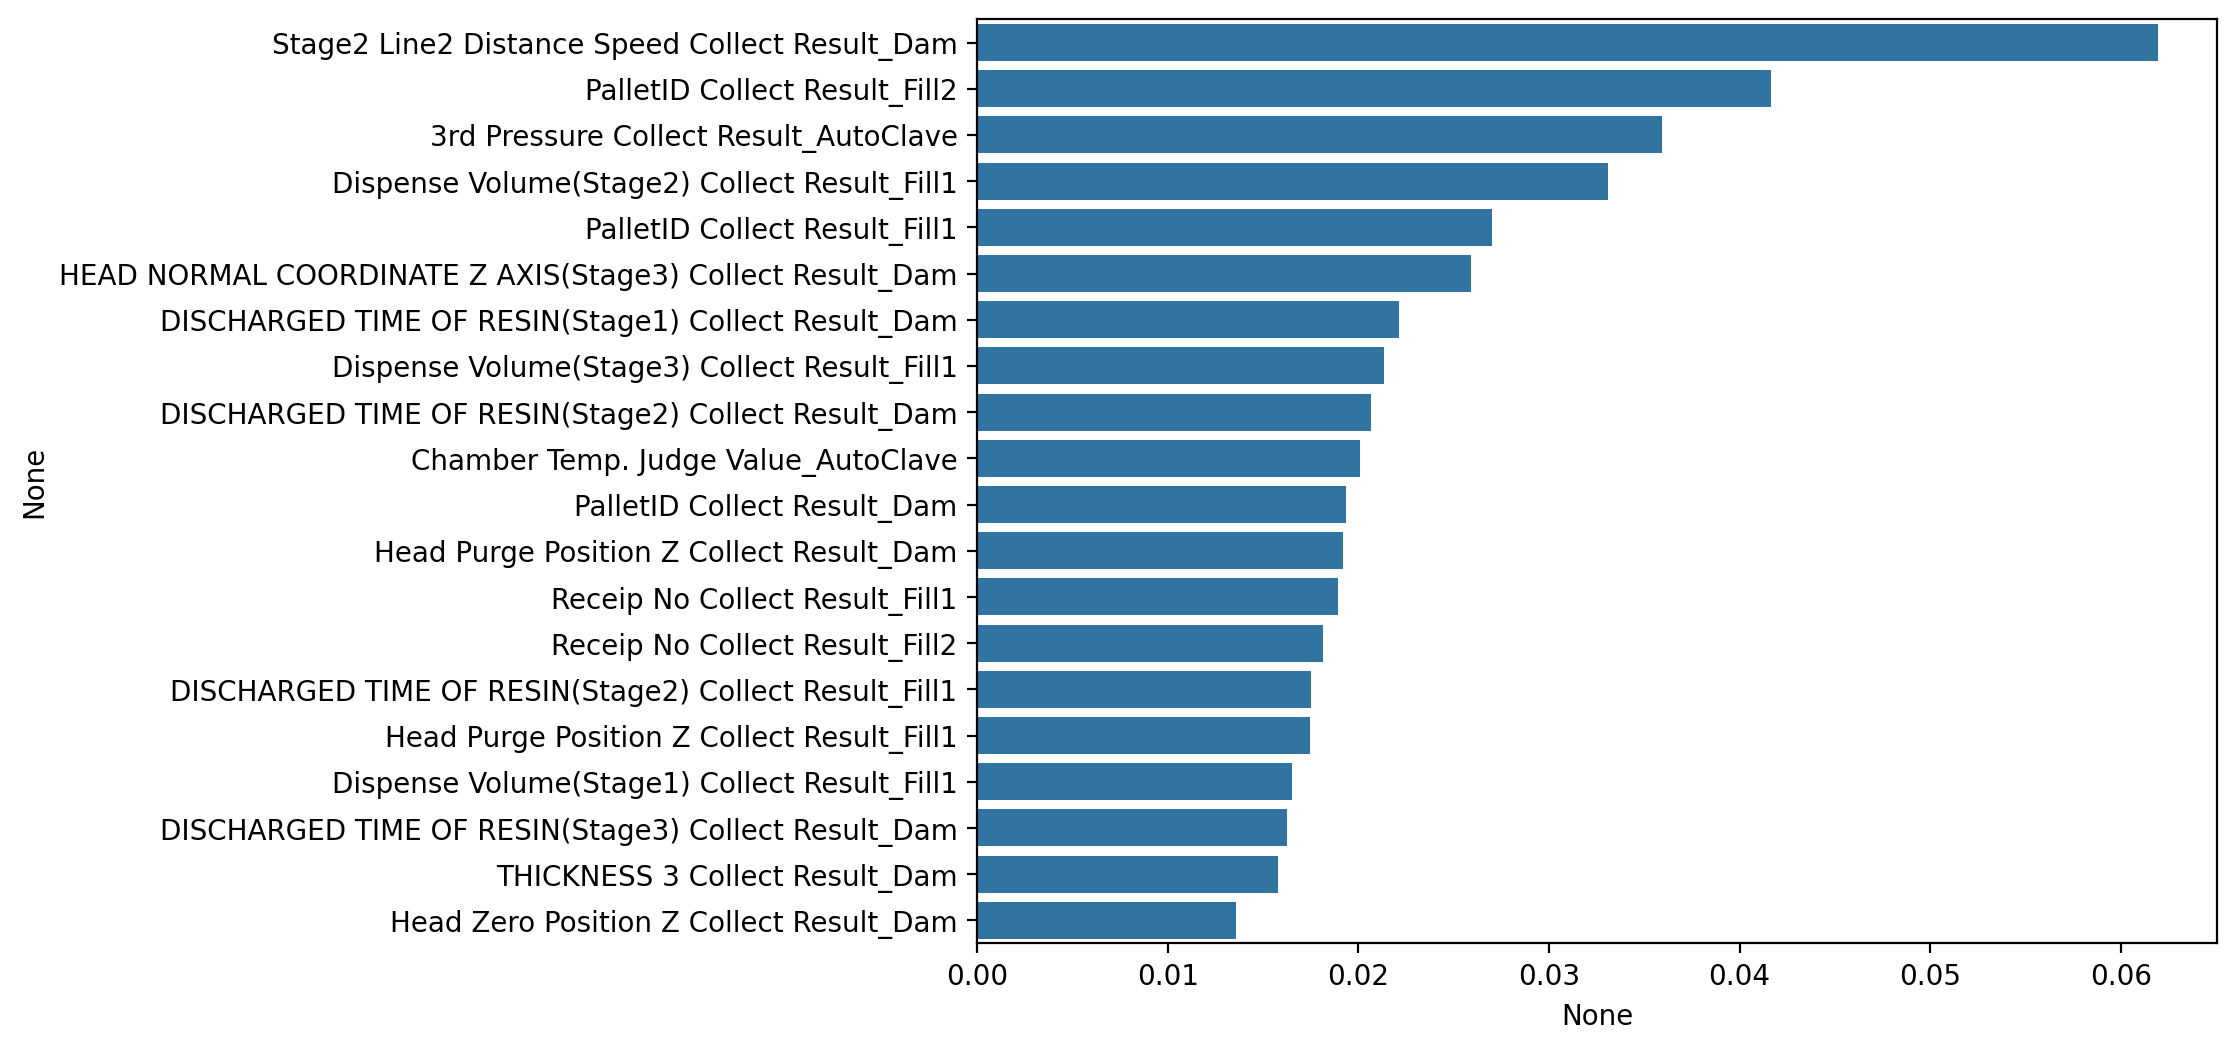

In [36]:
import matplotlib.pyplot as plt # 득점모델 변수 중요도 xgboost
import seaborn as sns
%matplotlib inline
 
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]
 
plt.figure(figsize=(8, 6))
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

In [35]:
test_pred = model.predict(x_test)

In [36]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

In [37]:
np.bincount(df_sub.loc[index1, 'target'])

array([10, 18])

In [87]:
df_sub.loc[index1, 'target']

64       0
562      0
1460     1
1530     1
1892     0
2505     1
2710     1
3457     1
3682     1
3732     1
4928     0
4932     1
6092     0
7001     0
7287     0
7666     1
7836     0
8253     1
8898     1
10989    1
12439    1
12585    1
12844    0
14756    1
15180    1
15406    0
15811    1
15964    1
Name: target, dtype: int64

In [88]:
df_sub.loc[index2, 'target']

363      0
626      0
721      0
1219     0
1544     0
1605     0
2338     0
3153     0
3231     0
3490     0
3782     0
4232     0
4254     0
4805     0
5093     0
5315     0
5362     0
5423     0
5613     0
5835     0
5863     0
5982     0
6035     0
6040     0
6303     1
6538     0
7511     0
7850     0
7909     0
7953     0
8606     0
8751     0
8969     0
9252     0
9294     0
11109    0
11736    0
12544    0
12560    0
12741    0
12882    0
13002    0
13075    0
13460    0
13992    0
14067    0
14284    0
14377    0
14910    0
15551    0
15700    0
16011    0
16864    0
Name: target, dtype: int64

In [89]:
df_sub.loc[index3, 'target']

250      0
711      0
791      0
1986     0
3337     0
4841     0
4868     0
5057     0
5384     0
5541     0
7099     0
8593     0
9334     0
12112    0
12232    0
12239    0
14377    0
14934    0
15181    0
15781    0
Name: target, dtype: int64

In [38]:
# 특정 인덱스에 대해 'target' 값을 설정
df_sub.loc[index1, 'target'] = 1
df_sub.loc[index2, 'target'] = 0
df_sub.loc[index3, 'target'] = 0
# 역매핑 정의
reverse_mapping = {0: 'Normal', 1: 'AbNormal'}

# 타겟 컬럼을 원래 값으로 되돌리기
df_sub['target'] = df_sub['target'].map(reverse_mapping)

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [39]:
df_sub['target'].value_counts()

target
Normal      16851
AbNormal      510
Name: count, dtype: int64

In [40]:
df_sub

,Set ID,target
0,0001be084fbc4aaa9d921f39e595961b,Normal
1,0005bbd180064abd99e63f9ed3e1ac80,Normal
2,000948934c4140d883d670adcb609584,Normal
3,000a6bfd02874c6296dc7b2e9c5678a7,Normal
4,0018e78ce91343678716e2ea27a51c95,Normal
...,...,...
17356,ffea508b59934d689b540f95eb3fa730,Normal
17357,ffed8923c8a448a98afc641b770be153,Normal
17358,fff1e73734da40adbe805359b3efb462,Normal
17359,fff8e38bdd09470baf95f71e92075dec,Normal


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = train_data[train_data["target"] == "Normal"]
df_abnormal = train_data[train_data["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

### 데이터 분할


In [ ]:
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.3,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}" + f" ratio: {num_abnormal/num_normal}")


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

## 3. 모델 학습


### 모델 정의


In [ ]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

### 모델 학습


In [ ]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

train_x = df_train[features]
train_y = df_train["target"]

model.fit(train_x, train_y)

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [ ]:
df_test_x = test_data[features]

for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [ ]:
test_pred = model.predict(df_test_x)
test_pred

### 제출 파일 작성


In [ ]:
df_sub = pd.read_csv("submission.csv")
df_sub

# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
